In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
#%matplotlib inline

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv2DTranspose, LeakyReLU, BatchNormalization, Activation
from keras.models import Model
from keras import losses, regularizers
from keras import backend as K
from keras import metrics

from vis.visualization import visualize_activation, visualize_activation_with_losses
from vis.regularizers import TotalVariation, LPNorm
from vis.losses import ActivationMaximization
from vis.input_modifiers import Jitter
                                                                   
import h5py
import importlib

sys.path.append('/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode')

import bastien_utils
import custom_regularizers

from sklearn.decomposition import PCA

/home/bastien/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import importlib
importlib.reload(bastien_utils)

<module 'bastien_utils' from '/home/bastien/Documents/StageCMM/Auto-encoders/SourceCode/bastien_utils.py'>

In [3]:
FILE_PATH = "../"

img_rows, img_cols, img_chns = 28, 28, 1

if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

In [4]:
data = bastien_utils.load_data(FILE_PATH, train=True, test=True, subsetTest=True)
x_train, ytrain, x_test, y_test, x_small, y_small = data
print('x_small shape:', x_small.shape)
print('x_test shape:', x_test.shape)

x_small shape: (10, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


# 1. Shallow AE

Shallow auto-encoder, with sigmoid activation in the encoder and lRELU activation in the decoder. MSE loss.

## 1.1 Simple

In [47]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim5_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
H_small_5 = encoder.predict(x_small)
x_rec_small_5 = decoder.predict(H_small_5)
H = encoder.predict(x_test)
print('Dimension 5 - Reconstruction error: ', autoencoder.evaluate(x_test, x_test))
print('Dimension 5 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))

10000/10000 [==============================] - 0s 42us/step
Dimension 5 - Reconstruction error:  0.034063106632232665
Dimension 5 - SVM classification score on learned representation:  0.7061999999999999


In [48]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim10_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
H_small_10 = encoder.predict(x_small)
x_rec_small_10 = decoder.predict(H_small_10)
H = encoder.predict(x_test)
print('Dimension 10 - Reconstruction error: ', autoencoder.evaluate(x_test, x_test))
print('Dimension 10 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))

10000/10000 [==============================] - 0s 45us/step
Dimension 10 - Reconstruction error:  0.025160937535762786
Dimension 10 - SVM classification score on learned representation:  0.743


In [49]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim100_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
H_small_100 = encoder.predict(x_small)
x_rec_small_100 = decoder.predict(H_small_100)
H = encoder.predict(x_test)
print('Dimension 100 - Reconstruction error: ', autoencoder.evaluate(x_test, x_test))
print('Dimension 100 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))

10000/10000 [==============================] - 1s 66us/step
Dimension 100 - Reconstruction error:  0.011654435408115386
Dimension 100 - SVM classification score on learned representation:  0.8003


In [50]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim1000_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
H_small_1000 = encoder.predict(x_small)
x_rec_small_1000 = decoder.predict(H_small_1000)
H = encoder.predict(x_test)
print('Dimension 1000 - Reconstruction error: ', autoencoder.evaluate(x_test, x_test))
print('Dimension 1000 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))

10000/10000 [==============================] - 3s 317us/step
Dimension 1000 - Reconstruction error:  0.005334228305518627
Dimension 1000 - SVM classification score on learned representation:  0.765


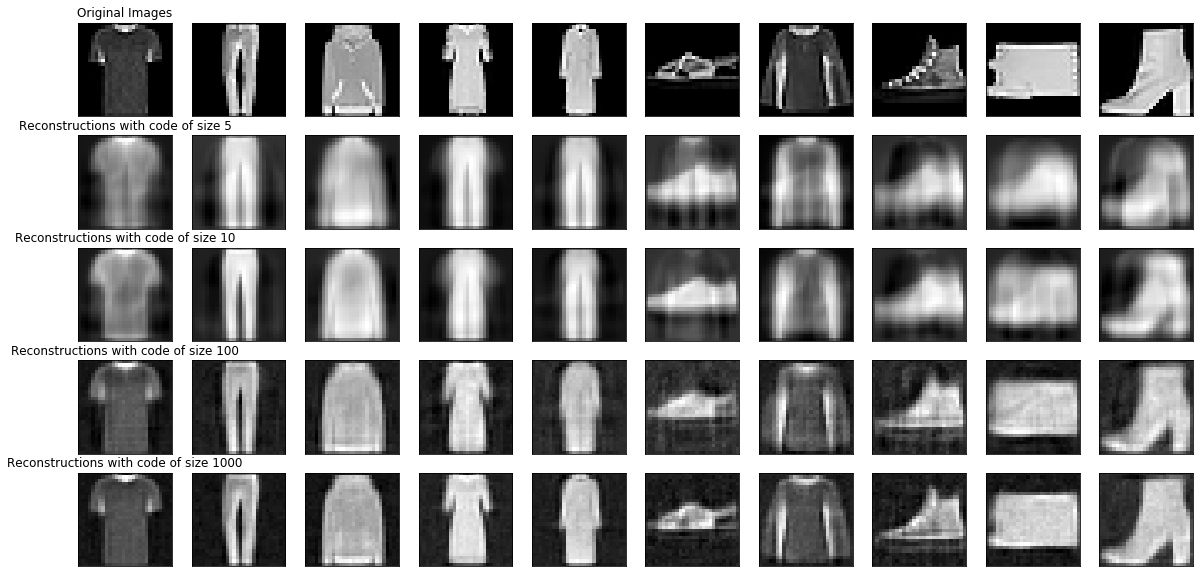

In [51]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_small[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Original Images')
  
    # display reconstruction dimension 5
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(x_rec_small_5[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if (i == 0):
        ax.set_title('Reconstructions with code of size 5')
    
    # display reconstruction dimension 10
    ax = plt.subplot(5, n, i + 1 + 2*n)
    plt.imshow(x_rec_small_10[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    if (i == 0):
        ax.set_title('Reconstructions with code of size 10')
    
    # display reconstruction dimension 5
    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(x_rec_small_100[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    if (i == 0):
        ax.set_title('Reconstructions with code of size 100')
    
    # display reconstruction dimension 5
    ax = plt.subplot(5, n, i + 1 + 4*n)
    plt.imshow(x_rec_small_1000[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    if (i == 0):
        ax.set_title('Reconstructions with code of size 1000')
    
plt.show()

## 1.2 Comparison with PCA

In [52]:
from sklearn.decomposition import PCA

In [55]:
dims = np.array([5, 10, 100])
x_rec_pca = []
for i, d in enumerate(dims):
    pca = PCA(n_components=d)
    pca.fit(x_train.reshape((x_train.shape[0], 28*28)))
    Hpca = pca.transform(x_test.reshape((x_test.shape[0], 28*28)))
    x_reconstruction_test_pca = pca.inverse_transform(Hpca).reshape((x_test.shape[0], 28, 28)) 
    print("PCA dimension ", str(d), " - Reconstruction error : ", np.mean((x_test[:,:,:,0] - x_reconstruction_test_pca)**2))
    print("PCA dimension ", str(d), " - SVM classification score on learned representation: ", bastien_utils.crossValSVM(Hpca, y_test))
    print('\n')
    H_small_pca = pca.transform(x_small.reshape((x_small.shape[0], 28*28)))
    x_rec_pca.append(pca.inverse_transform(H_small_pca).reshape((x_small.shape[0], 28, 28)))

PCA dimension  5  - Reconstruction error :  0.03328643
PCA dimension  5  - SVM classification score on learned representation:  0.7431


PCA dimension  10  - Reconstruction error :  0.024351517
PCA dimension  10  - SVM classification score on learned representation:  0.8092


PCA dimension  100  - Reconstruction error :  0.007691334
PCA dimension  100  - SVM classification score on learned representation:  0.8452999999999999




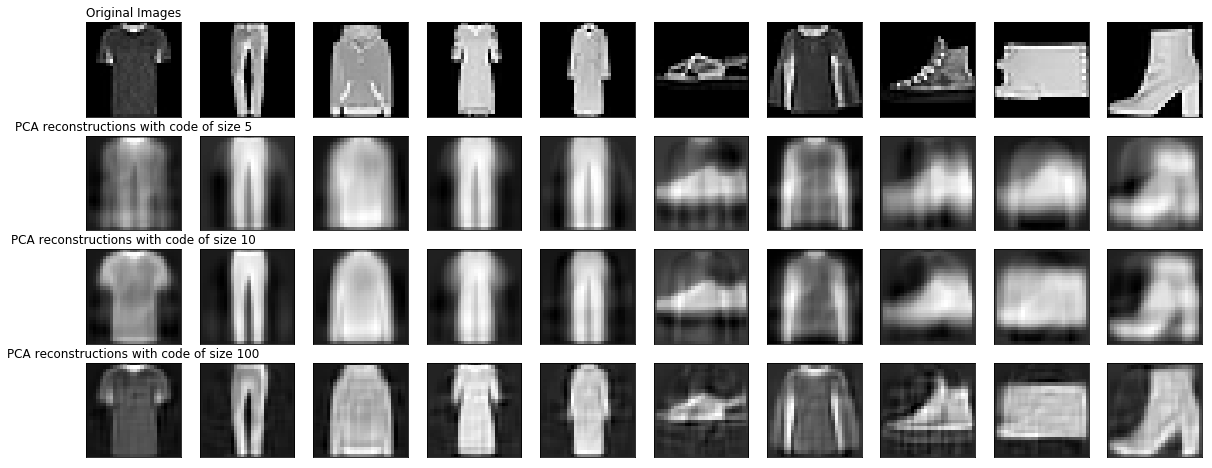

In [56]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 8))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_small[i, :,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if (i == 0):
        ax.set_title('Original Images')
  
    # display reconstruction dimension 5
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_rec_pca[0][i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if (i == 0):
        ax.set_title('PCA reconstructions with code of size 5')
    
    # display reconstruction dimension 10
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(x_rec_pca[1][i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    if (i == 0):
        ax.set_title('PCA reconstructions with code of size 10')
    
    # display reconstruction dimension 100
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(x_rec_pca[2][i,:,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)    
    if (i == 0):
        ax.set_title('PCA reconstructions with code of size 100')
    
plt.show()

## 1.3 Sparsity Constraint

### 1.3.a Visualizing weights of models without sparsity constraints

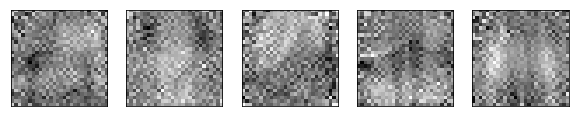

In [5]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim5_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
bastien_utils.plot_atoms(encoder)

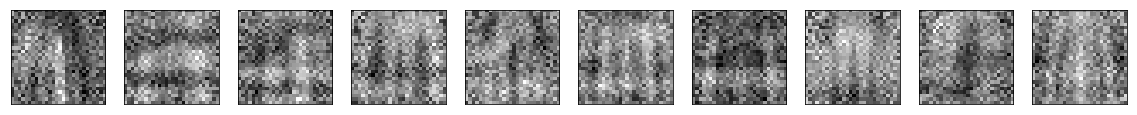

In [71]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim10_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
bastien_utils.plot_atoms(encoder)

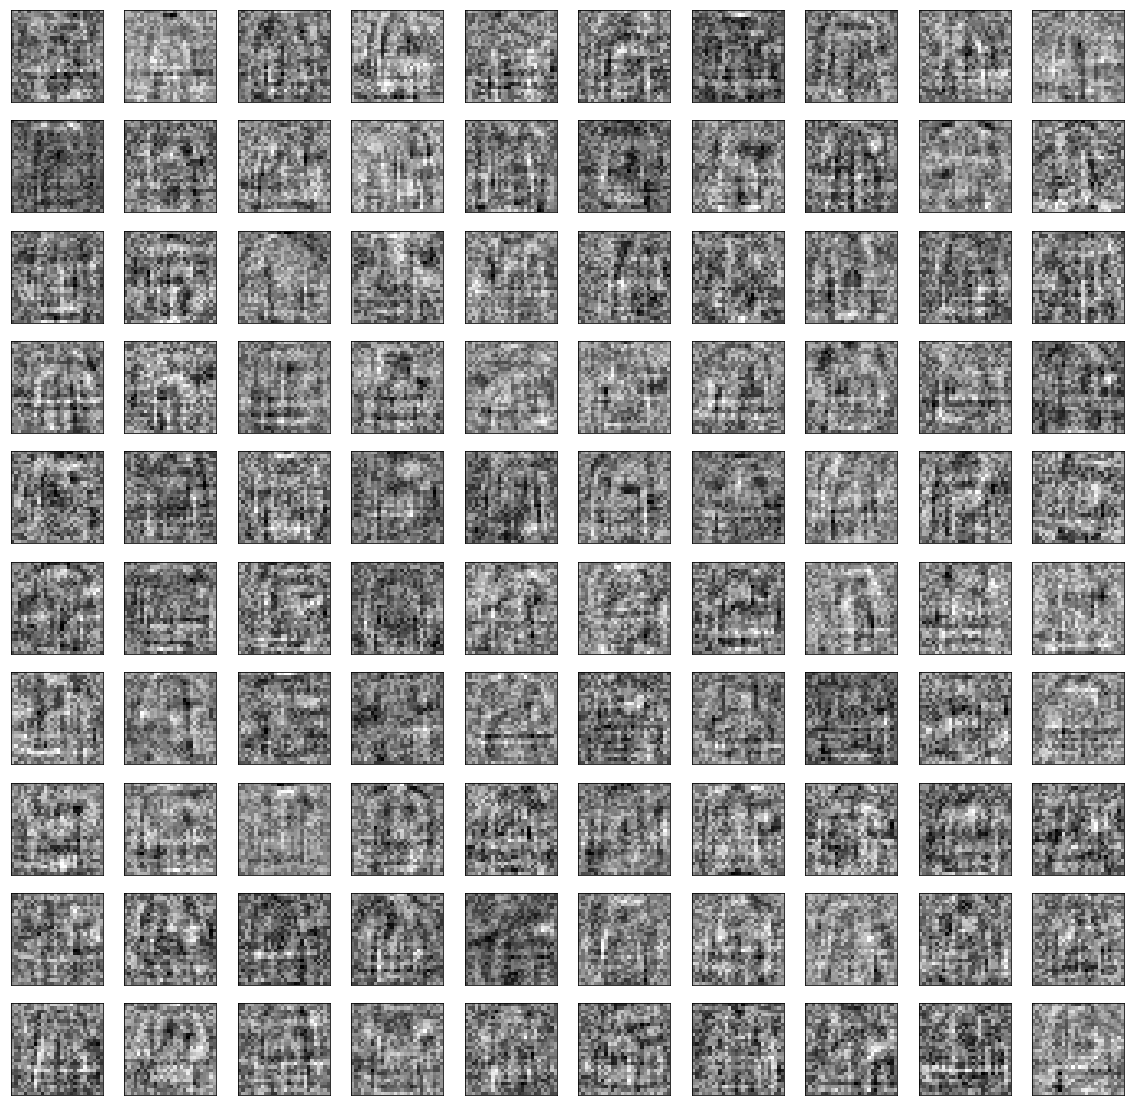

In [72]:
dir_models='../ShallowAE/Simple/Models/'
model_path= dir_models + 'dim100_sigE_MSE.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path)
bastien_utils.plot_atoms(encoder)

### 1.3.b Adding KL sparsity constraint

10000/10000 [==============================] - 0s 44us/step
Dimension 5 - Reconstruction error:  0.0370931
Dimension 5 - SVM classification score on learned representation:  0.6378999999999999


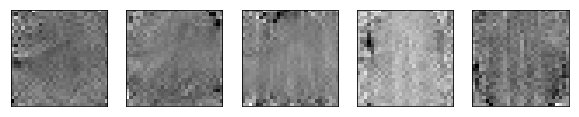

In [7]:
dir_models='../ShallowAE/Sparse/Models/'
model_path= dir_models + 'kl_dim5.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'KL_divergence':custom_regularizers.KL_divergence})
H_small_5_sparse = encoder.predict(x_small)
x_rec_small_5_sparse = decoder.predict(H_small_5_sparse)
H = encoder.predict(x_test)
print('Dimension 5 - Reconstruction error: ', np.mean(autoencoder.evaluate(x_test, x_test)))
print('Dimension 5 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))
bastien_utils.plot_atoms(encoder)

10000/10000 [==============================] - 1s 67us/step
Dimension 10 - Reconstruction error:  0.12272322
Dimension 10 - SVM classification score on learned representation:  0.5859


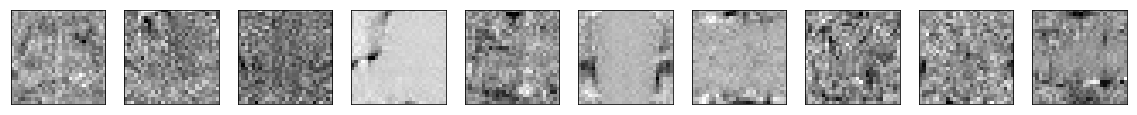

In [83]:
dir_models='../ShallowAE/Sparse/Models/'
model_path= dir_models + 'kl_dim10.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'kl_divergence':custom_regularizers.KL_divergence})
H_small_10_sparse = encoder.predict(x_small)
x_rec_small_10_sparse = decoder.predict(H_small_10_sparse)
H = encoder.predict(x_test)
print('Dimension 10 - Reconstruction error: ', np.mean(autoencoder.evaluate(x_test, x_test)))
print('Dimension 10 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))
bastien_utils.plot_atoms(encoder)

10000/10000 [==============================] - ETA:  - 2s 227us/step
Dimension 100 - Reconstruction error:  0.013588356
Dimension 100 - SVM classification score on learned representation:  0.7681000000000001


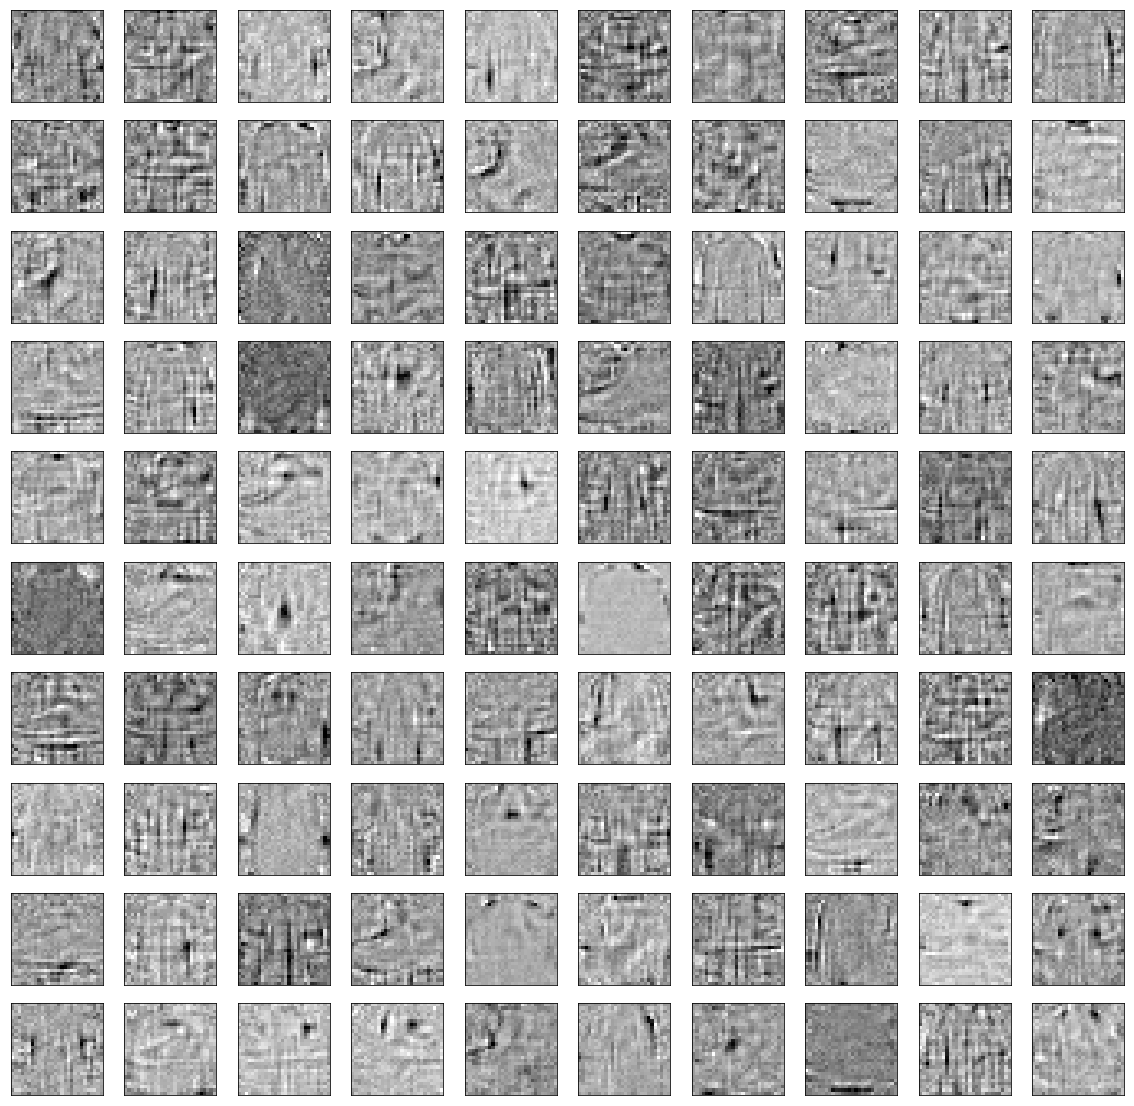

In [84]:
dir_models='../ShallowAE/Sparse/Models/'
model_path= dir_models + 'kl_dim100.h5'
autoencoder, encoder, decoder = bastien_utils.load_AE(model_path, custom_objects={'KL_divergence':custom_regularizers.KL_divergence})
H_small_100_sparse = encoder.predict(x_small)
x_rec_small_100_sparse = decoder.predict(H_small_100_sparse)
H = encoder.predict(x_test)
print('Dimension 100 - Reconstruction error: ', np.mean(autoencoder.evaluate(x_test, x_test)))
print('Dimension 100 - SVM classification score on learned representation: ', bastien_utils.crossValSVM(H, y_test))
bastien_utils.plot_atoms(encoder)